<a href="https://colab.research.google.com/github/akurtovic4/SquirrelSearchAlgorithm/blob/main/SSOAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install niapy


In [ ]:
import numpy as np
from scipy.special import gamma


def ssa_algorithm(objective_function, population_size, food_sources, prob_predation, gliding_constant, scale, max_iteration, lower_bounds, upper_bounds, dimension):

    def initialize_population(population_size, dimension, rng, lower_bounds, upper_bounds):
      # Generisanje random brojeva u opsegu za svaku dimenziju
      return lower_bounds + rng.random(size=(population_size, dimension)) * (upper_bounds - lower_bounds)


    # Funkcija za generisanje Levy-jevog leta
    def levy_flight(size, rng):
        beta = 1.5
        sigma = (gamma(1 + beta) * np.sin(np.pi * beta / 2) / (gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
        u = rng.normal(0, sigma, size)
        v = rng.normal(0, 1, size)
        step = u / abs(v) ** (1 / beta)
        return step


    # Glavna funkcija za jednu iteraciju algoritma
    def run_iteration(locations, fitness_values, food_sources, prob_predation, gliding_constant, scale, max_iterations, rng, iteration):


        max_broj_iteracija = max_iterations

        # Sortiranje vjeverica na drveću prema fitnessu
        indexi = np.argsort(fitness_values)

        # Prikaz sortiranih vrijednosti fitnesa
        sorted_fitness_values = fitness_values[indexi]
        # print("Sortirani po fitnesu:", sorted_fitness_values)

        # Prikaz vrijednosti prvog elementa u sortiranom nizu
        prva_vrijednost = sorted_fitness_values[0]
        # print("Vrijednost prvog elementa:", prva_vrijednost)


        # Deklaracija vjeverica na "hickory nut tree", "acorn nuts tree" i "normal tree"
        ht = indexi[0]
        at = indexi[1:food_sources]
        nt = indexi[food_sources:]

        new_locations = locations.copy()


        # Racunanje distance klizanja
        def gliding_distance(scale):
          lift = 0.9783723933835806 / np.random.uniform(0.675, 1.5)
          drag = 1.630620655639301
          return 8.0 / (scale * drag / lift)

        # Prilagodjava vrijednosti novih lokacija da budu unutar granica
        def repair(solution, lower_bounds, upper_bounds):
          repaired_solution = np.maximum(lower_bounds, np.minimum(solution, upper_bounds))
          return repaired_solution

        # Slucaj 1
        # Vjeverice koje su na "acorn trees" i kreću se prema "hickory nut tree" u skladu sa pseudokodom.

        for index in at:
            if rng.random() >= prob_predation:
                new_locations[index] += gliding_distance(scale) * gliding_constant * (locations[ht] - locations[index])
            else:
                new_locations[index] = rng.uniform(lower_bounds, upper_bounds, size=locations.shape[1])


        # Random premjestanje sa "normal trees" na "hickory nut trees" i sa "normal trees" na "acorn trees"
        # Prva i treca cetvrtina na nt_1 a druga i cetvrta na nt_2
        nt = rng.permutation(nt)
        nt_1 = np.concatenate((nt[:len(nt) // 4], nt[3 * len(nt) // 4:]))
        nt_2 = np.concatenate((nt[len(nt) // 4:3 * len(nt) // 4],))


        # Slucaj 2
        # Ukupan broj vjeverica koje su na "normal trees" i koje se premjestaju na "acorn tree"
        for index in nt_1:
            if rng.random() >= prob_predation:
                a = rng.choice(at)
                new_locations[index] +=gliding_distance(scale)* gliding_constant * (locations[a] - locations[index])
            else:
                new_locations[index] = rng.uniform(lower_bounds, upper_bounds, size=locations.shape[1])

        # Slucaj 3
        # Ukupan broj vjeverica koje su na "normal trees" i koje se premjestaju na "hickory nut tree"
        for index in nt_2:
            if rng.random() >= prob_predation:
                new_locations[index] += gliding_distance(scale)* gliding_constant * (locations[ht] - locations[index])
            else:
                new_locations[index] = rng.uniform(lower_bounds, upper_bounds, size=locations.shape[1])


        s_min = 1e-5 / (365 ** ((iteration + 1) / (max_broj_iteracija / 2.5)))

        # Racunanje sezonske konstante
        sc = np.sqrt(np.sum((new_locations[at] - new_locations[ht]) ** 2))

        # Sezonalni monitoring
        if sc < s_min:
            new_locations[nt_1] = lower_bounds + levy_flight(size=(len(nt_1), dimension), rng=rng) * (upper_bounds - lower_bounds)
            new_locations[nt_1] = repair(new_locations[nt_1], lower_bounds, upper_bounds)

        return new_locations, sc



    # Generisanje random lokacija za prvu populaciju vjeverica
    rng = np.random.default_rng()
    locations = initialize_population(population_size, dimension, rng, lower_bounds, upper_bounds)

    # Racunanje fitness za prvu populaciju
    fitness_values = np.apply_along_axis(objective_function, 1, locations)
    best_location = locations[np.argmin(fitness_values)]

    # print("Best fitness", best_location)



    # Glavna petlja algoritma
    for iteration in range(1, max_iterations + 1):
        locations, seasonal_constant = run_iteration(locations, fitness_values, food_sources, prob_predation, gliding_constant, scale, max_iterations, rng, iteration)
        fitness_values = np.apply_along_axis(objective_function, 1, locations)

        # Ažuriranje najboljeg rešenja
        current_best_location = locations[np.argmin(fitness_values)]
        if objective_function(current_best_location) < objective_function(best_location):
            best_location = current_best_location


    return best_location


Best solution: [ 5.97837307e-14 -4.44563649e-14]
Objective value: 5.5504628423705924e-27


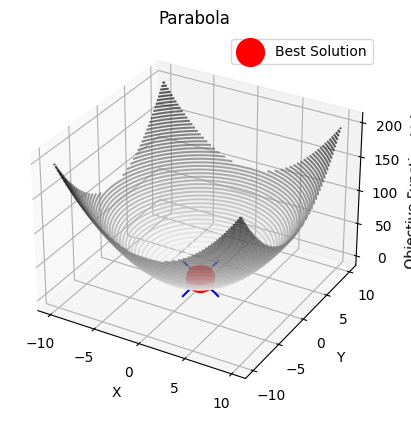

In [ ]:
import matplotlib.pyplot as plt

def objective_function(x):
    return np.sum(x**2, axis=0)

funkcija = lambda x: np.sum(x**2)


x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = funkcija(np.array([X[j, i], Y[j, i]]))


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour(X, Y, Z, 50, alpha=0.7, cmap='binary')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Objective Function Value')
ax.set_title('Parabola')

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 500
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(funkcija, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {funkcija(best_solution)}')
ax.scatter(0, 0, 0, color='blue',s=700, marker='x')
ax.scatter(best_solution[0], best_solution[1], funkcija(best_solution), color='red', s=400, label='Best Solution')

plt.legend()
plt.show()

Best solution: [4.69103010e-02 3.12865454e-08]
Objective value: 0.002200577316508339


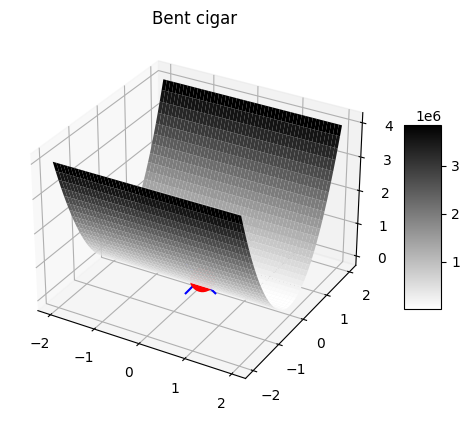

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

"""def bent_cigar_function(x,y):
    return x**2 + 1e6 * y**2"""

def bent_cigar_function(v):
  #raspakivanje koordinara
	x, y = v
	return x**2 + 1e6 * y**2


funkcija = lambda x, y: x**2 + 1e6 * y**2
funkcija1 = lambda x: x[0]**2 + 1e6 * x[1]**2


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = funkcija(X, Y)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 3000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(funkcija1, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {funkcija1(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Bent cigar')
ax.scatter(0, 0, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], funkcija1(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()





Best solution: [ 3.57210620e-02 -1.16681572e-07]
Objective value: 1.2760078864094893e-09


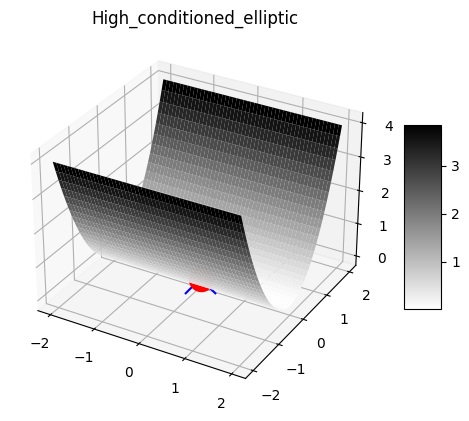

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

def high_conditioned_elliptic_function(x):
    a = 1e6
    d = len(x)
    return np.sum([a**((i-1)/(d-1))*(x[i]**2) for i in range(d)])

a = 1e6
high_conditioned_elliptic_lambda = lambda x: np.sum([a**((i-1)/(len(x)-1))*(x[i]**2) for i in range(len(x))])



#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

# Evaluate the function at each point in the meshgrid
for i in range(len(x)):
    for j in range(len(y)):
        point = [X[i, j], Y[i, j]]
        Z[i, j] = high_conditioned_elliptic_lambda(point)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(high_conditioned_elliptic_lambda, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {high_conditioned_elliptic_lambda(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('High_conditioned_elliptic')
ax.scatter(0, 0, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], high_conditioned_elliptic_lambda(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()





Best solution: [1. 1.]
Objective value: 6.302739538425428e-20


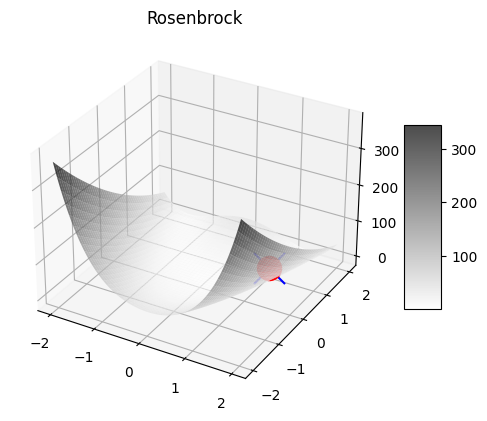

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

def rosenbrock_function(v):
     x, y = v
     return np.sum(100 * (y - x**2)**2 + (1 - x)**2)

b = 10;
rosenbrock_lambda = lambda x, y: (x-1)**2 + b*(y-x**2)**2;
rosenbrock_lambda1 = lambda x: (x[0]-1)**2 + b*(x[1]-x[0]**2)**2;


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = rosenbrock_lambda(X, Y)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(rosenbrock_lambda1, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {rosenbrock_lambda1(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Rosenbrock')
ax.scatter(1, 1, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], rosenbrock_lambda1(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z,alpha = 0.7, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()





Best solution: [ 9.28011037e-17 -1.98523063e-16]
Objective value: 0.0


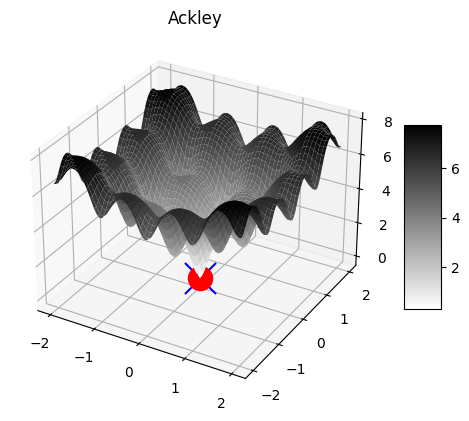

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def ackley_function(v):
    x, y = v
    term1 = -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
    term3 = np.exp(1) + 20.0
    return term1 + term2 + term3


ackley_lambda = lambda x, y: (-20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
                             - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
                             + np.exp(1) + 20.0)
ackley_lambda1 = lambda x: (-20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
                             - np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1])))
                             + np.exp(1) + 20.0)


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = ackley_lambda(X, Y)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(ackley_lambda1, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {ackley_lambda1(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Ackley')
ax.scatter(0, 0, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], ackley_lambda1(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()





Best solution: [ 8.90703298e-10 -9.92838512e-10]
Objective value: 0.0


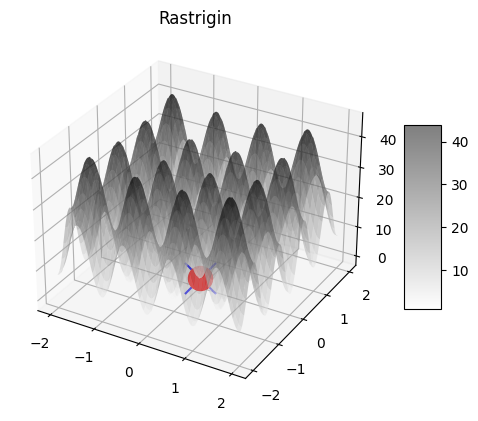

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

def rastrigin_function(v, A=10):
    x, y = v
    return 2*A + x**2 - A*np.cos(2*np.pi*x) + y**2 - A*np.cos(2*np.pi*y)

A = 10;
rastrigin_lambda = lambda x, y: 2*A + x**2 - A*np.cos(2*np.pi*x) + y**2 - A*np.cos(2*np.pi*y)
rastrigin_lambda1 = lambda x: 2*A + x[0]**2 - A*np.cos(2*np.pi*x[0]) + x[1]**2 - A*np.cos(2*np.pi*x[1])


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = rastrigin_lambda(X, Y)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(rastrigin_lambda1, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {rastrigin_lambda1(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Rastrigin')
ax.scatter(0, 0, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], rastrigin_lambda1(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z,alpha = 0.5, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()





Best solution: [-1.18829499e-09 -6.37903415e-09]
Objective value: 0.0


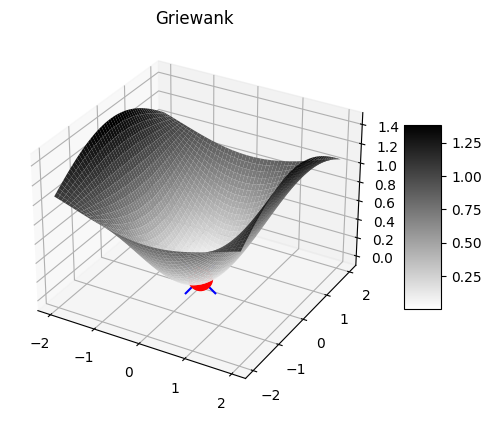

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

def griewank_function(v):
    x1, x2 = v
    return (x1 ** 2 + x2 ** 2)/4000.0 - math.cos(x1) * math.cos(x2 / math.sqrt(2)) + 1.0


griewank_lambda = lambda x1, x2: (x1 ** 2 + x2 ** 2)/4000.0 - np.cos(x1) * np.cos(x2 / np.sqrt(2)) + 1.0
griewank_lambda1 = lambda x: (x[0] ** 2 + x[1] ** 2)/4000.0 - np.cos(x[0]) * np.cos(x[1] / np.sqrt(2)) + 1.0


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = griewank_lambda(X, Y)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(griewank_lambda1, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {griewank_lambda1(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Griewank')
ax.scatter(0, 0, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], griewank_lambda1(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()





Best solution: [5.2391991  5.23919913]
Objective value: 830.0751967494313


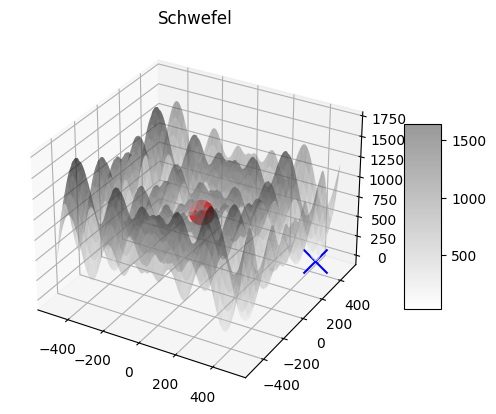

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

def schwefel_function(x):
    n = len(x)
    return 418.9829 * n - np.sum([x[i] * np.sin(np.sqrt(np.abs(x[i])))for i in range(n)])


schwefel_lambda = lambda x: 418.9829 * len(x) - np.sum([x[i] * np.sin(np.sqrt(np.abs(x[i])))for i in range(len(x))])



#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)

X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

# Evaluate the function at each point in the meshgrid
for i in range(len(x)):
    for j in range(len(y)):
        point = [X[i, j], Y[i, j]]
        Z[i, j] = schwefel_lambda(point)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(schwefel_lambda, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {schwefel_lambda(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Schwefel')
ax.scatter(420.9687, 420.9687, 0, color='blue',s=300, marker='x')
ax.scatter(best_solution[0], best_solution[1], schwefel_lambda(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z, alpha = 0.4,cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Best solution: [-0.02562354  0.02700963]
Objective value: 0.5000014409258503


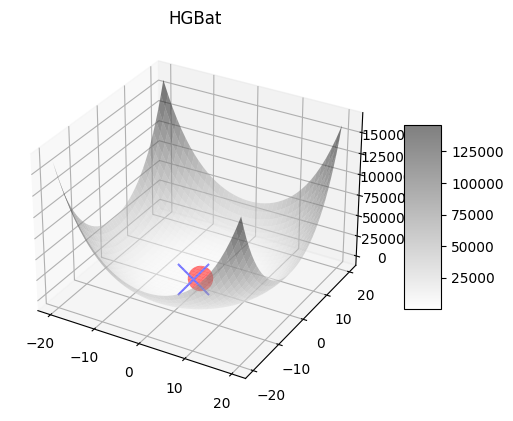

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def hgbat_function(x):
    a = [-10, -5]
    term1 = np.sum((x - a) ** 2) ** 2
    term2 = np.sum(x - a) ** 2 / 1e6
    return term1 + term2

a = [-10, -5]
hgbat_lambda1 = lambda x: (np.sum((x - a) ** 2) ** 2
                             + np.sum(x - a) ** 2 / 1e6)

hgbat_lambda = lambda x: 0.5 + np.sqrt(np.abs((np.sum([x[i] ** 2 for i in range(len(x))])) ** 2 - (np.sum([x[i] for i in range(len(x))])) ** 2)) + (0.5 * (np.sum([x[i] ** 2 for i in range(len(x))])) ** 2 + (np.sum([x[i] for i in range(len(x))])) ** 2) / len(x)

#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-20, 20, 40)
y = np.linspace(-20, 20, 40)

X, Y = np.meshgrid(x, y)

Z = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i][j] = hgbat_lambda(np.array([X[i][j], Y[i][j]]))

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 6000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(hgbat_lambda, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {hgbat_lambda(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('HGBat')
ax.scatter(-1, -1, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], hgbat_lambda(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z,alpha = 0.5, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Best solution: [1.94741555e-18 2.94002473e-05]
Objective value: 0.30000000086437456


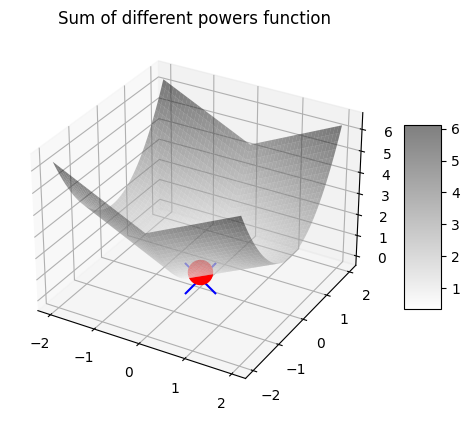

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

def sum_of_different_powers_function(x, a=0.1):
    n = len(x)
    return np.sum(np.abs(x[i]) ** (i+1)for i in range(len(x)))

sum_of_different_powers_lambda1 = lambda x: np.sum([(np.abs(x[i]) ** (i+1))for i in range(len(x))])
sum_of_different_powers_lambda = lambda x, a=0.1: np.sum([(np.abs(x[i]) ** (i+1) + a * (i+1)) for i in range(len(x))])


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

# Evaluate the function at each point in the meshgrid
for i in range(len(x)):
    for j in range(len(y)):
        point = [X[i, j], Y[i, j]]
        Z[i, j] = sum_of_different_powers_lambda(point)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(sum_of_different_powers_lambda, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {sum_of_different_powers_lambda(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Sum of different powers function')
ax.scatter(0, 0, 0, color='blue',s=500, marker='x')
ax.scatter(best_solution[0], best_solution[1], sum_of_different_powers_lambda(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z, alpha = 0.5,cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Best solution: [ 3.40001772e-15 -6.45542167e-16]
Objective value: 1.2081026330052979e-29


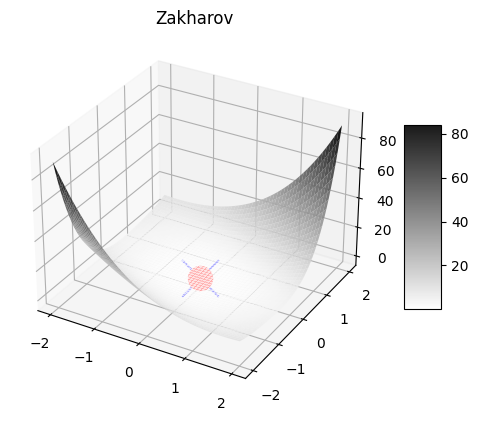

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math


zakharov_lambda = lambda x: np.sum([x[i] ** 2 for i in range(len(x))]) + np.sum([0.5 * i * x[i] for i in range(len(x))]) ** 2 + np.sum([0.5 * (i+1) * x[i] for i in range(len(x))]) ** 4


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

# Evaluate the function at each point in the meshgrid
for i in range(len(x)):
    for j in range(len(y)):
        point = [X[i, j], Y[i, j]]
        Z[i, j] = zakharov_lambda(point)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(zakharov_lambda, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {zakharov_lambda(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Zakharov')
ax.scatter(0, 0, 0, color='blue',s=700, marker='x')
ax.scatter(best_solution[0], best_solution[1], zakharov_lambda(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z,alpha=0.9, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Best solution: [1. 1.]
Objective value: 1.3991573266960716e-24


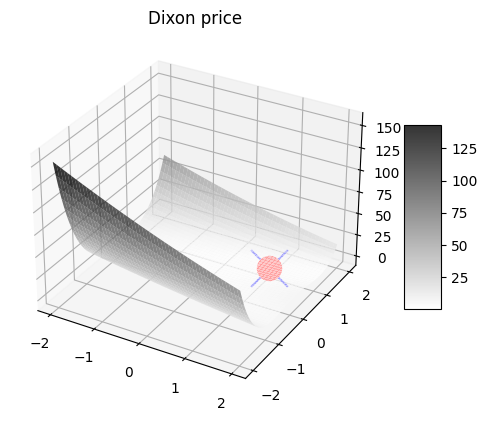

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math


dixon_price_lambda = lambda x: (x[1]-1) ** 2 + np.sum([i * 2*(x[i] ** 2) - x[i-1] for i in range(len(x))]) ** 2


#x_min, x_max = -2, 2
#y_min, y_max = -2, 2


#X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)

X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

# Evaluate the function at each point in the meshgrid
for i in range(len(x)):
    for j in range(len(y)):
        point = [X[i, j], Y[i, j]]
        Z[i, j] = dixon_price_lambda(point)

dimension = 2
population_size = 50
food_sources = 4
prob_predation = 0.1
gliding_constant = 1.9
scale = 18
max_iterations = 2000
lower_bounds = -10
upper_bounds = 10
best_solution = ssa_algorithm(dixon_price_lambda, population_size, food_sources, prob_predation, gliding_constant, scale, max_iterations, lower_bounds, upper_bounds, dimension)
print(f'Best solution: {best_solution}')
print(f'Objective value: {dixon_price_lambda(best_solution)}')




# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(1, 1, 0, color='blue',s=700, marker='x')
ax.set_title('Dixon price')
ax.scatter(best_solution[0], best_solution[1], dixon_price_lambda(best_solution), color='red', s=300, label='Best Solution')
surf = ax.plot_surface(X, Y, Z,alpha=0.8, cmap='binary')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()